## Building a Robot Judge
### Problem Set 3

In [74]:
#*************#
#   imports   #
#*************#

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import spacy

from gensim.models import Word2Vec

from keras.layers import Input, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE


nlp = spacy.load('en')


# limits the number of cases
LIMIT = 500

In [76]:
#************************************************************#
#   create 'master' data set, which contains all metadatas   #
#************************************************************#
cases = pd.read_csv("data/case_metadata.csv")
cases = cases.set_index('caseid').T.to_dict('list')
    
# cases is organized as follows: 
# {caseid : [case_reversed, judge_id, year, x_republican, log_cites]}
dic = {'case_reversed':0, 'judge_id':1, 'year':2, 'x_republican':3, 'log_cites':4}


casesList = os.listdir("data/cases/")

casesSpacy = {}

for caseName in casesList[:LIMIT]:
    casesSpacy[caseName[5:-4]] = nlp(open("data/cases/" + caseName).read())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """


### 1.

In [2]:
####################################################################################################
#                                                                                                  #
# Train a word embedding (Word2Vec, GloVe, ELMo, BERT, etc) on your corpus, once with a small      #
# window (e.g. 2) and again with a long window (e.g. 16). What do you expect to change for the     #
# different window sizes? Pick a sample of 100 words and visualize them in two dimensions, to      # 
# demonstrate the difference between the models.                                                   #
#                                                                                                  #
####################################################################################################

In [13]:
#***************************************#
#   train a word embedding (Word2Vec)   #
#***************************************#
sentences = []

for case in casesSpacy.values():
    for sentence in case.sents:
        sentences.append([token.text.lower() for token in sentence 
                          if not token.is_punct and not token.is_space
                          and len(token.text) > 3])
        
# print(sentences)

w2vSmall = Word2Vec(sentences, size=100, window=2, min_count=2)
w2vLong = Word2Vec(sentences, size=100, window=16, min_count=2)

In [5]:
#**********************************************************************************#
#   define tnse plot                                                               #
#   (source: https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne)   #
#**********************************************************************************#
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        if len(tokens) >= 100:    # changed to only plot 100
            break
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


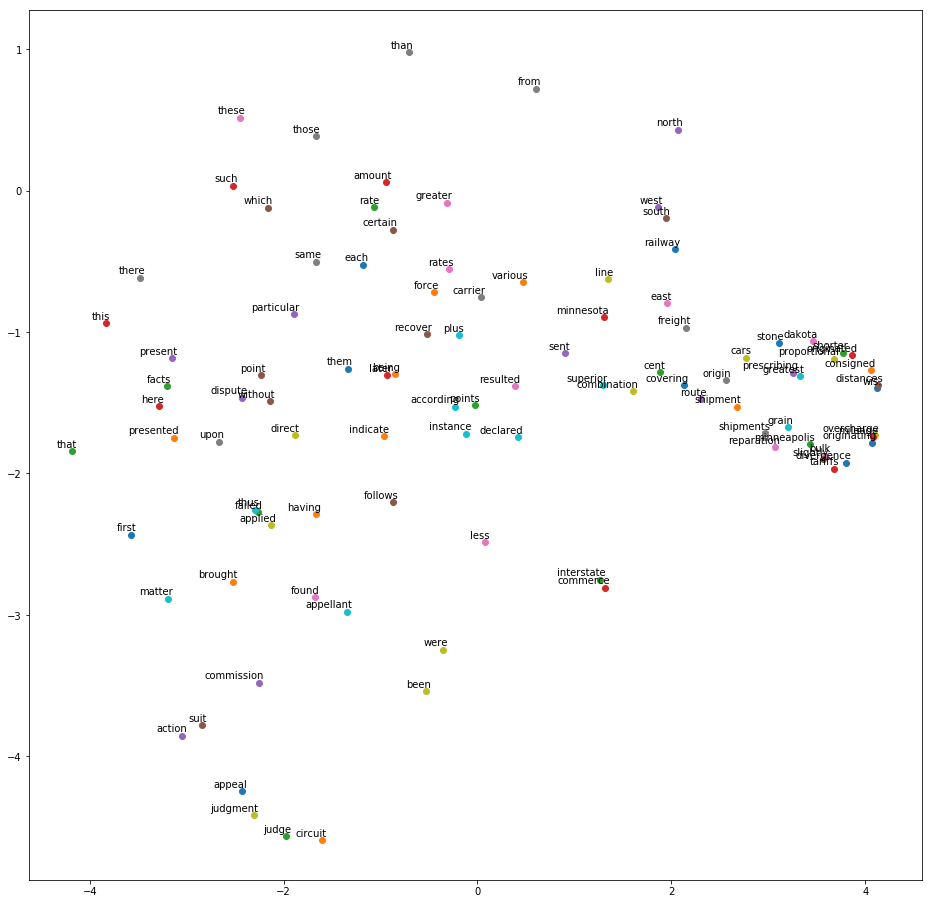

In [16]:
#*******************************************#
#   visualize 100 words in two dimensions   #
#*******************************************#
tsne_plot(w2vSmall)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


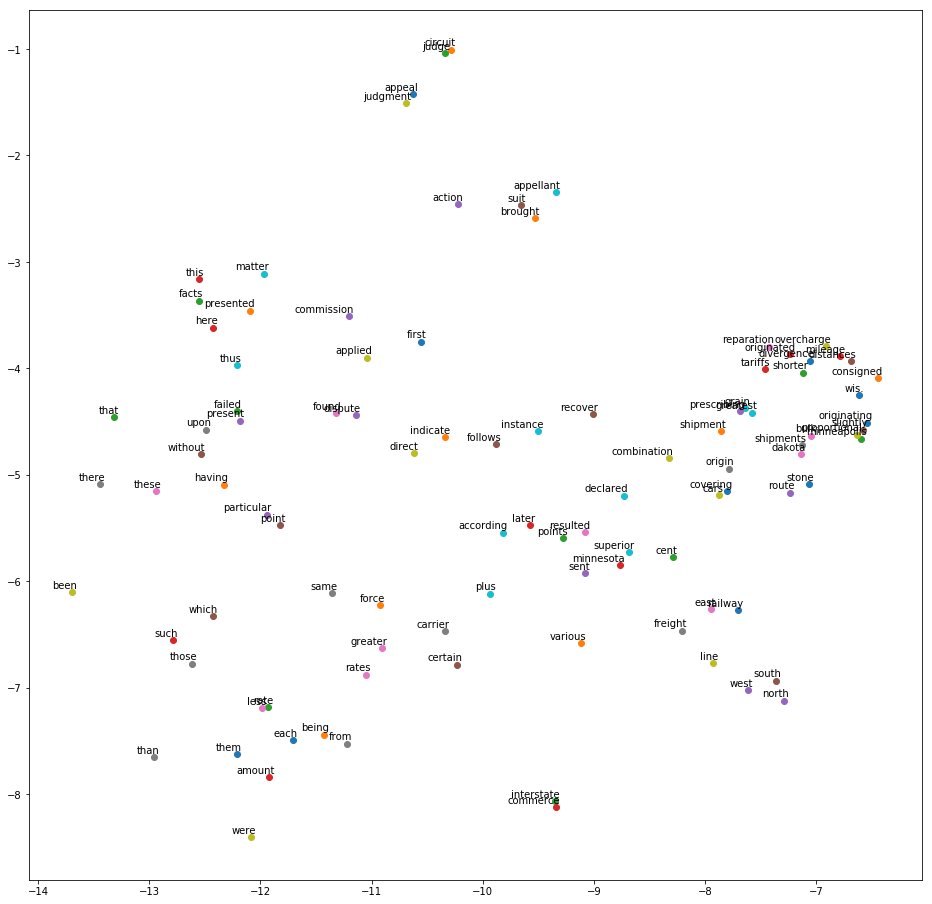

In [15]:
tsne_plot(w2vLong)

### 2.

In [ ]:
####################################################################################################
#                                                                                                  #
# Train separate word embeddings for Republican and Democrat judges. Use your word embeddings      #
# to list the adjectives most associated with a social group or concept of your choice, and        #
# analyze differences by judge party.                                                              #
#                                                                                                  #
####################################################################################################

In [10]:
#******************************************************#
#   split cases/sentences in republican and democrat   #
#******************************************************#
repSentences = []
demSentences = []

for caseId, case in casesSpacy.items():
    for sentence in case.sents:
        if cases[caseId][dic['x_republican']] == 1:
            repSentences.append([token.text.lower() for token in sentence
                                 if not token.is_punct and not token.is_space
                                 and len(token.text) > 2])
        else:
            demSentences.append([token.text.lower() for token in sentence
                                 if not token.is_punct and not token.is_space
                                 and len(token.text) > 2])

In [11]:
#***************************#
#   train word embeddings   #
#***************************#
w2vRep = Word2Vec(repSentences, size=100, window=5, min_count=5)
w2vDem = Word2Vec(demSentences, size=100, window=5, min_count=5)

In [12]:
#****************************************#
#   analyze differences by judge party   #
#****************************************#
rep = w2vRep.wv.similar_by_word('government', topn=10)
print("Republicans, most similar to government:\n", rep)

dem = w2vDem.wv.similar_by_word('government', topn=10)
print("Democrats, most similar to government:\n", dem)

Republicans, most similar to government:
 [('fact', 0.9864380955696106), ('consider', 0.985249400138855), ('facts', 0.9831125736236572), ('matter', 0.9825730323791504), ('first', 0.9821488261222839), ('defendant', 0.9807106256484985), ('determine', 0.9801446795463562), ('issues', 0.9787530899047852), ('therefore', 0.9785451292991638), ('conclude', 0.9785297513008118)]
Democrats, most similar to government:
 [('privilege', 0.944754421710968), ('effect', 0.937156617641449), ('plaintiff', 0.9325147867202759), ('remembered', 0.9255234003067017), ('navy', 0.9240163564682007), ('lands', 0.9238489866256714), ('proposition', 0.9176090955734253), ('over', 0.9170373678207397), ('since', 0.9161416292190552), ('exercise', 0.912437915802002)]


### 3.

In [ ]:
####################################################################################################
#                                                                                                  #
# Implement one of the causal inference methods from Lecture 12 (choose one of the                 #
# following options):                                                                              #
#                                                                                                  #
#   a. Look at the effect of text features on citations or reversal (Fong and Grimmer 2016,        #
#      Hartford et al 2017, or Wang and Blei 2018)                                                 #
#                                                                                                  #
#   b. Look at the effect of political party on citations or reversal holding text features        #
#      constant (Roberts-Stewart-Nielsen 2018 matching method or Chernozhukov et al 2017           #
#      double ML method).                                                                          #
#                                                                                                  #
#   c. Look at heterogeneous effects of political party on citations or reversal depending on      #
#      text features (Wager and Athey 2017).                                                       #
#                                                                                                  #
####################################################################################################

In [50]:
#**********************#
#   normalize corpus   #
#**********************#
casesNorm = {}
for caseId, case in casesSpacy.items():
    normCase = ""
    for token in case:
        if token.pos_ == "ADJ":
            normCase += token.text + " "
        elif token.pos_ == "ADV":
            normCase += token.text + " "
        elif token.pos_ == "NOUN":
            normCase += token.text + " "
        elif token.pos_ == "PROPN":
            normCase += token.text + " "
        elif token.pos_ == "VERB":
            normCase += token.text + " "

    casesNorm[caseId] = normCase

In [77]:
#**********************#
#   vectorize corpus   #
#**********************#
dataX = CountVectorizer().fit_transform(list(casesNorm.values())).toarray()
dataY = [cases[caseId][dic['case_reversed']] for caseId in casesNorm.keys()]

trainX = np.array(dataX)
trainY = np.array(dataY)

trainX = trainX[: int(len(trainX) * 0.9)]
trainY = trainY[: int(len(trainY) * 0.9)]

testX = trainX[int(len(trainX) * 0.9) :]
testY = trainY[int(len(trainY) * 0.9) :]

In [85]:
#*********************************************#
#   train model to infer reversal from text   #
#*********************************************#
x = Input((trainX.shape[1],))
y = Dense(800, activation="relu")(x)
y = Dropout(0.5)(y)
y = Dense(400, activation="relu")(y)
y = Dropout(0.7)(y)
y = Dense(400, activation="relu")(y)
y = Dropout(0.9)(y)
y = Dense(200, activation="relu")(y)
y = Dropout(0.9)(y)
y = Dense(100, activation="relu")(y)
y = Dropout(0.9)(y)
y = BatchNormalization()(y)
y = Dropout(0.9)(y)
y = Dense(1, activation="sigmoid")(y)

model = Model(x, y)
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

model.summary()

# train model
history = model.fit(x=trainX, y=trainY, batch_size=16, epochs=100, validation_split=0.2)

# test model
acc = model.evaluate(testX, testY, batch_size=16)

print("test accuracy better model:", acc[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 27985)             0         
_________________________________________________________________
dense_56 (Dense)             (None, 800)               22388800  
_________________________________________________________________
dropout_29 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 400)               320400    
_________________________________________________________________
dropout_30 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 400)               160400    
_________________________________________________________________
dropout_31 (Dropout)         (None, 400)               0         
__________

360/360 [==============================] - 6s 16ms/step - loss: 0.2365 - acc: 0.6583 - val_loss: 0.2459 - val_acc: 0.5889
Epoch 46/100
360/360 [==============================] - 6s 16ms/step - loss: 0.2588 - acc: 0.6361 - val_loss: 0.2464 - val_acc: 0.5889
Epoch 47/100
360/360 [==============================] - 6s 16ms/step - loss: 0.2551 - acc: 0.6083 - val_loss: 0.2460 - val_acc: 0.5889
Epoch 48/100
360/360 [==============================] - 6s 17ms/step - loss: 0.2428 - acc: 0.6278 - val_loss: 0.2461 - val_acc: 0.5889
Epoch 49/100
360/360 [==============================] - 6s 17ms/step - loss: 0.2683 - acc: 0.6000 - val_loss: 0.2466 - val_acc: 0.5889
Epoch 50/100
360/360 [==============================] - 6s 17ms/step - loss: 0.2536 - acc: 0.6500 - val_loss: 0.2463 - val_acc: 0.5889
Epoch 51/100
360/360 [==============================] - 6s 17ms/step - loss: 0.2449 - acc: 0.6250 - val_loss: 0.2461 - val_acc: 0.5889
Epoch 52/100
360/360 [==============================] - 6s 17ms/step